# Working with Unlabeled Data – Cluster Analysis
Find the best number of clusters with __k_means__ and __agglomerative clustering__

## Overview

1. Load the data file
    - check the shape and plot the content  
1. Observe the pair plot and comment the shapes in view of clustering 
    1. if necessary, transform the data
1. Use the elbow method to find the optimal number of clusters, to do this test `KMeans` with varying number of clusters, from 2 to 10: for each value of `k` 
    - fit the data
    - compute the __inertia__ and the __silhouette score__  
    - store them for plot
1. Plot inertia and silhouette score versus `k`
1. Choose the optimal number of clusters looking at the plots
1. Cluster the data using the optimal number, plot the cluster assignment 
    - in the plot choose the features that seem to be most promising
1. For comparison, repeat the same operation with the `AgglomerativeClustering`
        

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

random_state = 42 # This variable will be used in all the procedure calls allowing a random_state parameter
               # in this way the running can be perfectly reproduced
               # just change this value for a different experiment

## 1. Load the data file
Check the shape and plot the content 

In [2]:
X_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv'
delimiter = ','
X = pd.read_csv(X_url, delimiter=delimiter)
X.shape

(440, 8)

In [3]:
X.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


## 2. Observe the data distributions

In [4]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_mms = pd.DataFrame(mms.fit_transform(X), columns=X.columns)

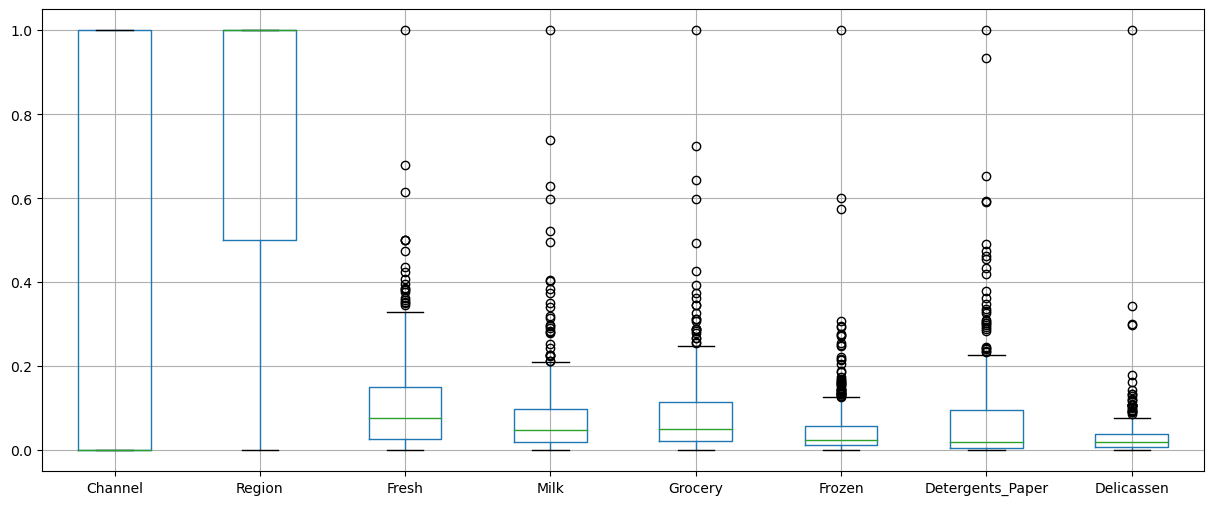

In [5]:
X_mms.boxplot(figsize=(15,6));

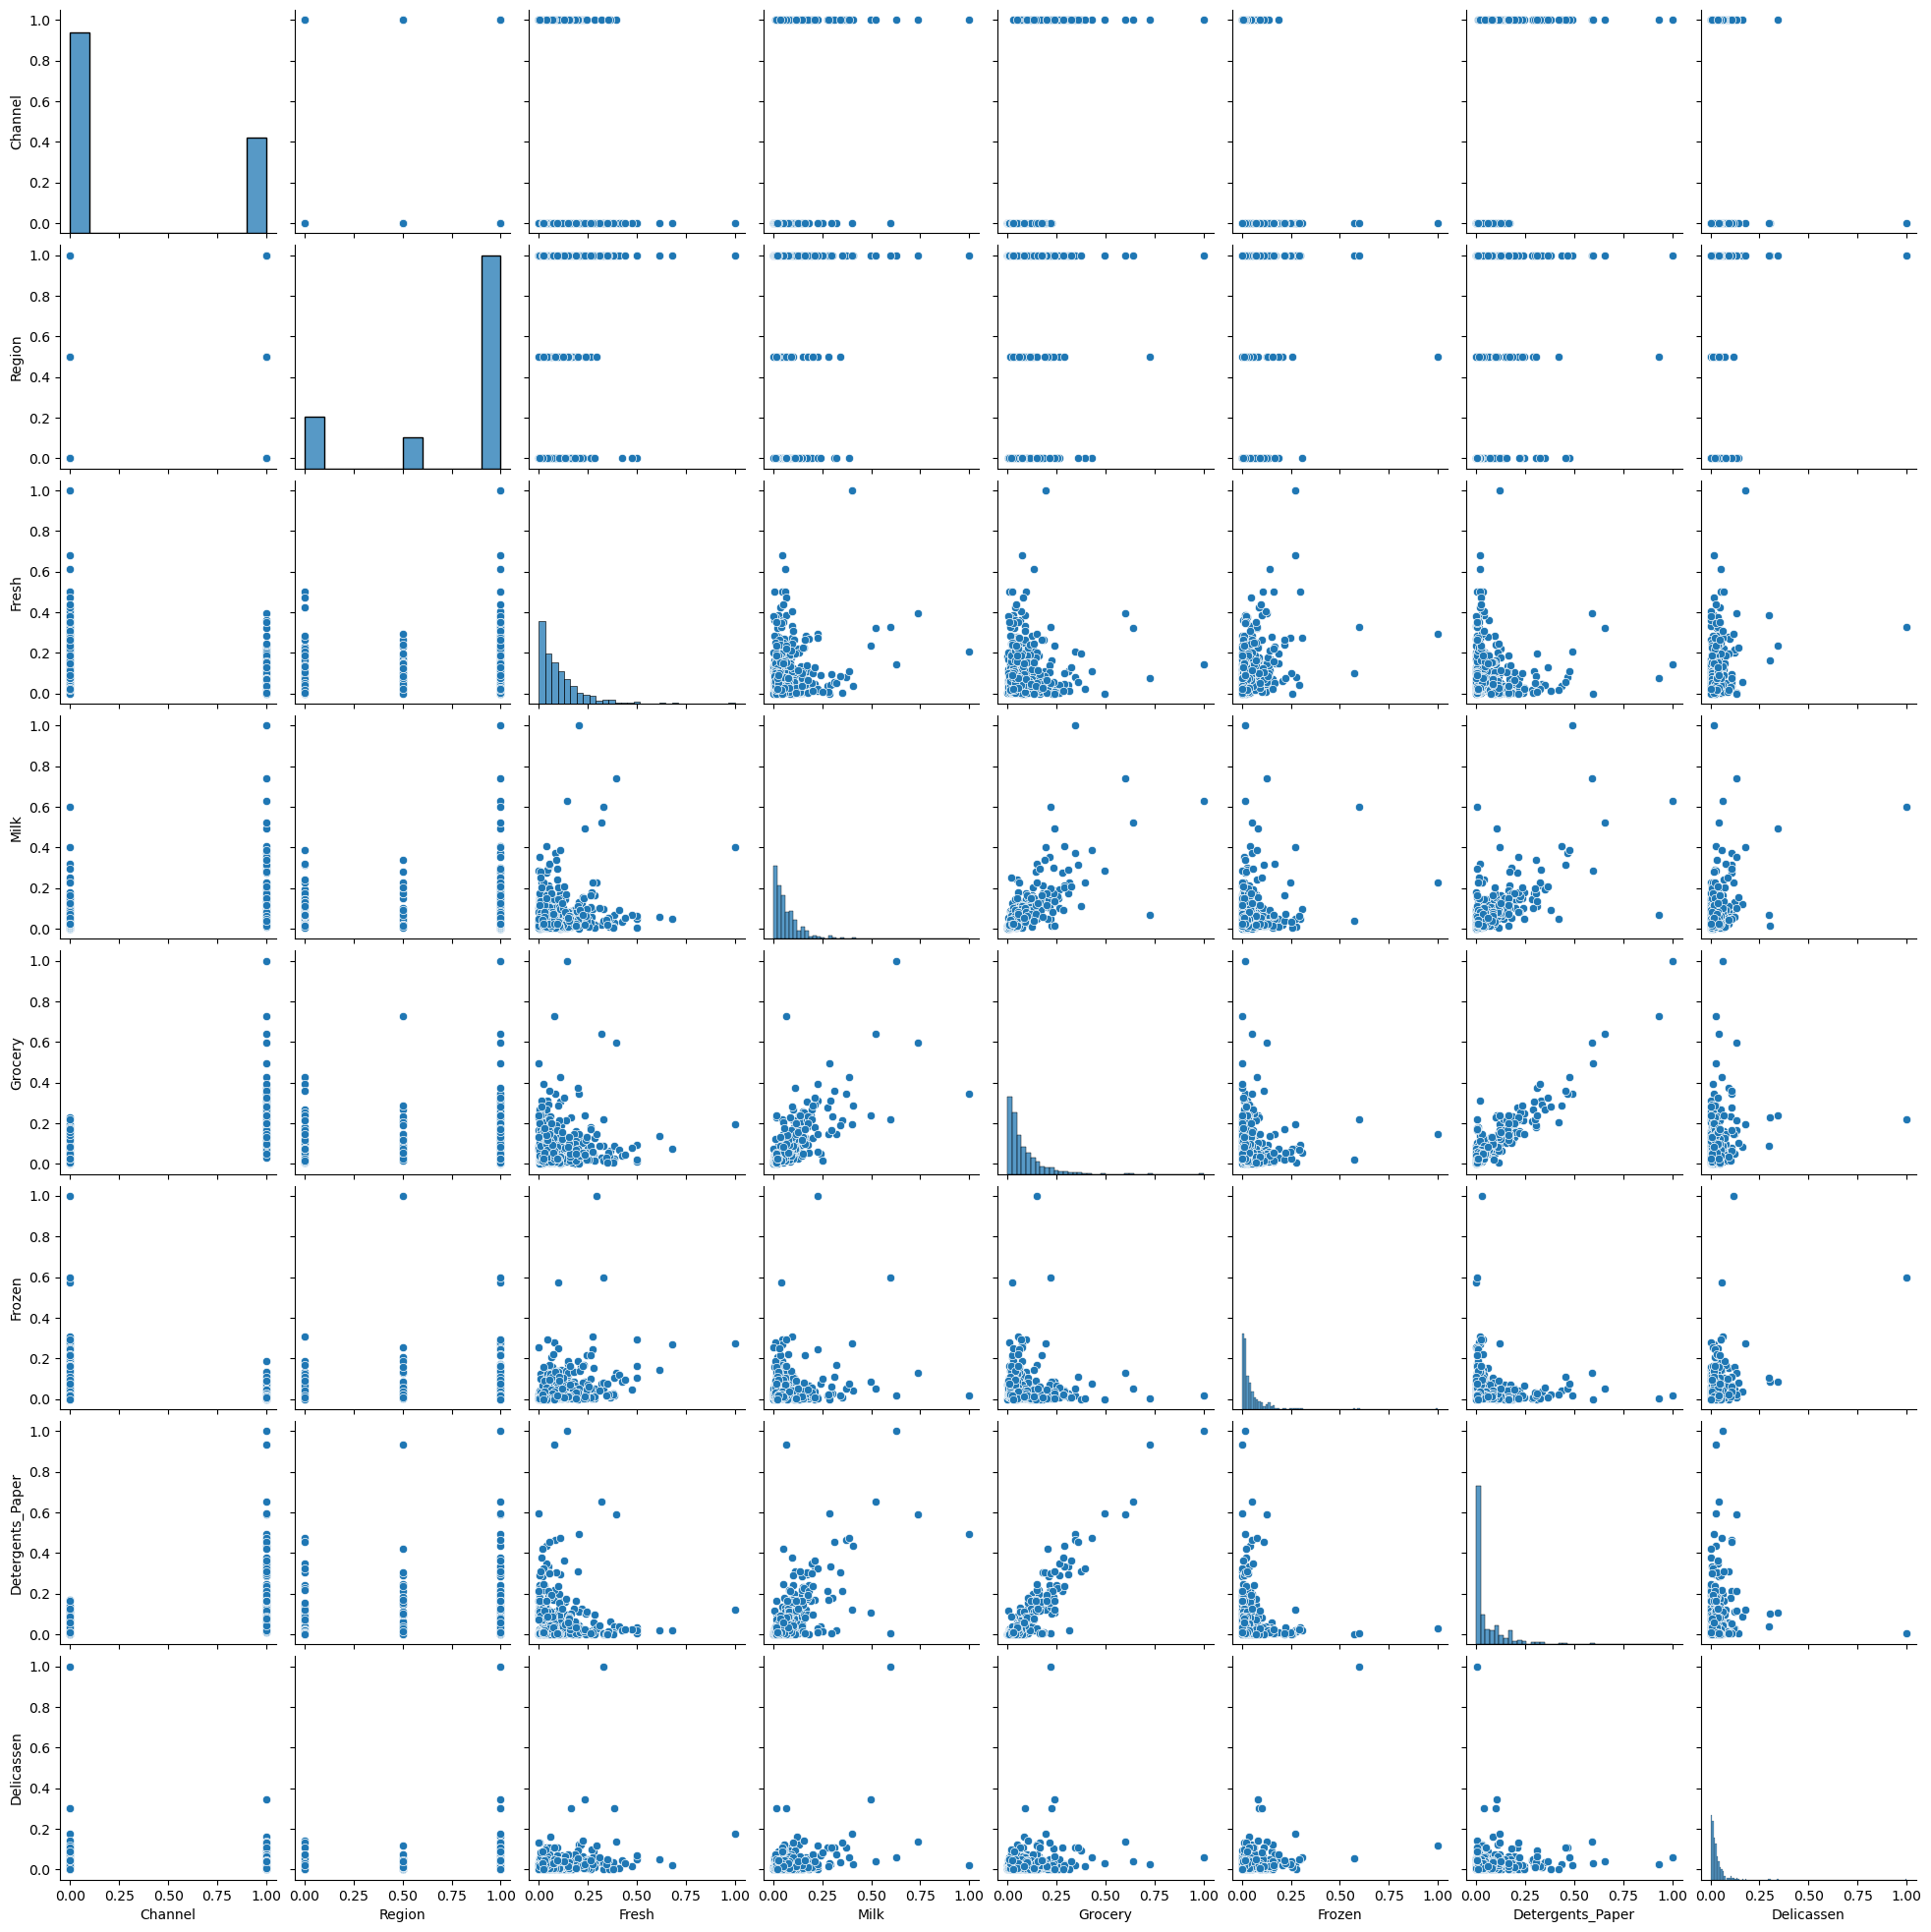

In [6]:
sns.pairplot(X_mms);
plt.show()

Now the effect of outliers is reduced, and we compute the clustering

## 3. Use the elbow method to find the optimal number of clusters
Test `KMeans` with varying number of clusters, from 2 to 10

Prepare the results list that will contain pairs of `inertia` and `silhouette_score` for each value of `k`, then, __for each value__ of `k` 
- initialize an estimator for `KMeans`
- fit the data and predict the cluster assignment for each individual with `fit` and `predict`
- the __inertia__ is provided in the attribute `inertia_` of the fitted model
- compute the __silhouette score__  using the function `silhouette_score` from `sklearn.metrics` using as arguments the data and the fitted labels, we will fill the variable `silhouette_scores`
- store the two values above in the list created at the beginning

In [7]:
from sklearn.model_selection import ParameterGrid
# import warnings
# warnings.filterwarnings("ignore")

k_range = list(range(2,11)) # set the range of k values to test 
parameters_km = [{'n_clusters': k_range}]
pg = list(ParameterGrid(parameters_km))
inertias_km = []
silhouette_scores_km = []
for i in range(len(pg)):
    km = KMeans(**(pg[i]), random_state=random_state)
    y_km = km.fit_predict(X)
    inertias_km.append(km.inertia_)
    silhouette_scores_km.append(silhouette_score(X,y_km))

## 4. Plot __inertia__ and __silhouette score__ versus `k`

In [8]:
from two_plots import two_plots

In [9]:
help(two_plots)

Help on function two_plots in module two_plots:

two_plots(x, y1, y2, xlabel, y1label, y2label)
    two_plots - produces two plots with different scales of the values of two
                dependent variables with different scales, one on the left and one on the right, 
                as function of the same independent variable 
    parameters:
    - x     : a range of values for the independent variable  
    - y1, y2: lists of values of the same length of x
    - xlabel: label for the horizontal axis
    - y1label, y2label : labels for the left and right axes



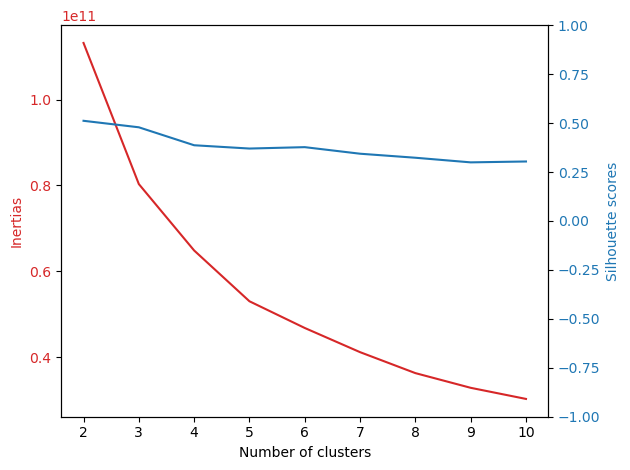

In [10]:
two_plots(x=k_range, y1=inertias_km, y2=silhouette_scores_km
          , xlabel='Number of clusters', y1label='Inertias', y2label='Silhouette scores'
         )

## 5. Cluster with the optimal number
The two *elbow* points of inertia would suggest as cluster number 3 or 4, slightly more pronounced in 3. Silhouette has a maximum on 4, but the increase with respect to 3 is very small.

We will choose k=3, due to the *knee* of the inertia, despite the silhouette that would suggest 2

In [11]:
k=3
km = KMeans(n_clusters=k, 
            random_state=random_state)
y_km = km.fit_predict(X)
print("Number of clusters = {}\t- Distortion = {:6.2f}\t- Silhouette score = {:4.2f}"\
    .format(k,inertias_km[k_range.index(k)],silhouette_scores_km[k_range.index(k)]))

Number of clusters = 3	- Distortion = 80332414178.03	- Silhouette score = 0.48


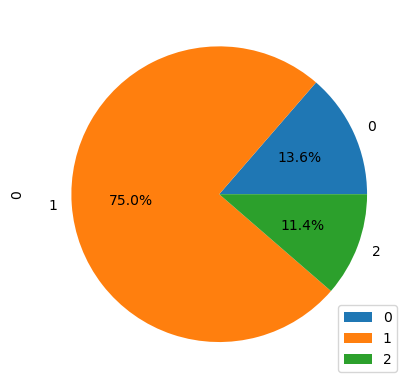

In [12]:
clust_sizes_km = np.unique(y_km,return_counts=True)
pd.DataFrame(clust_sizes_km[1]).plot.pie(subplots=True,autopct='%1.1f%%', );
plt.show()

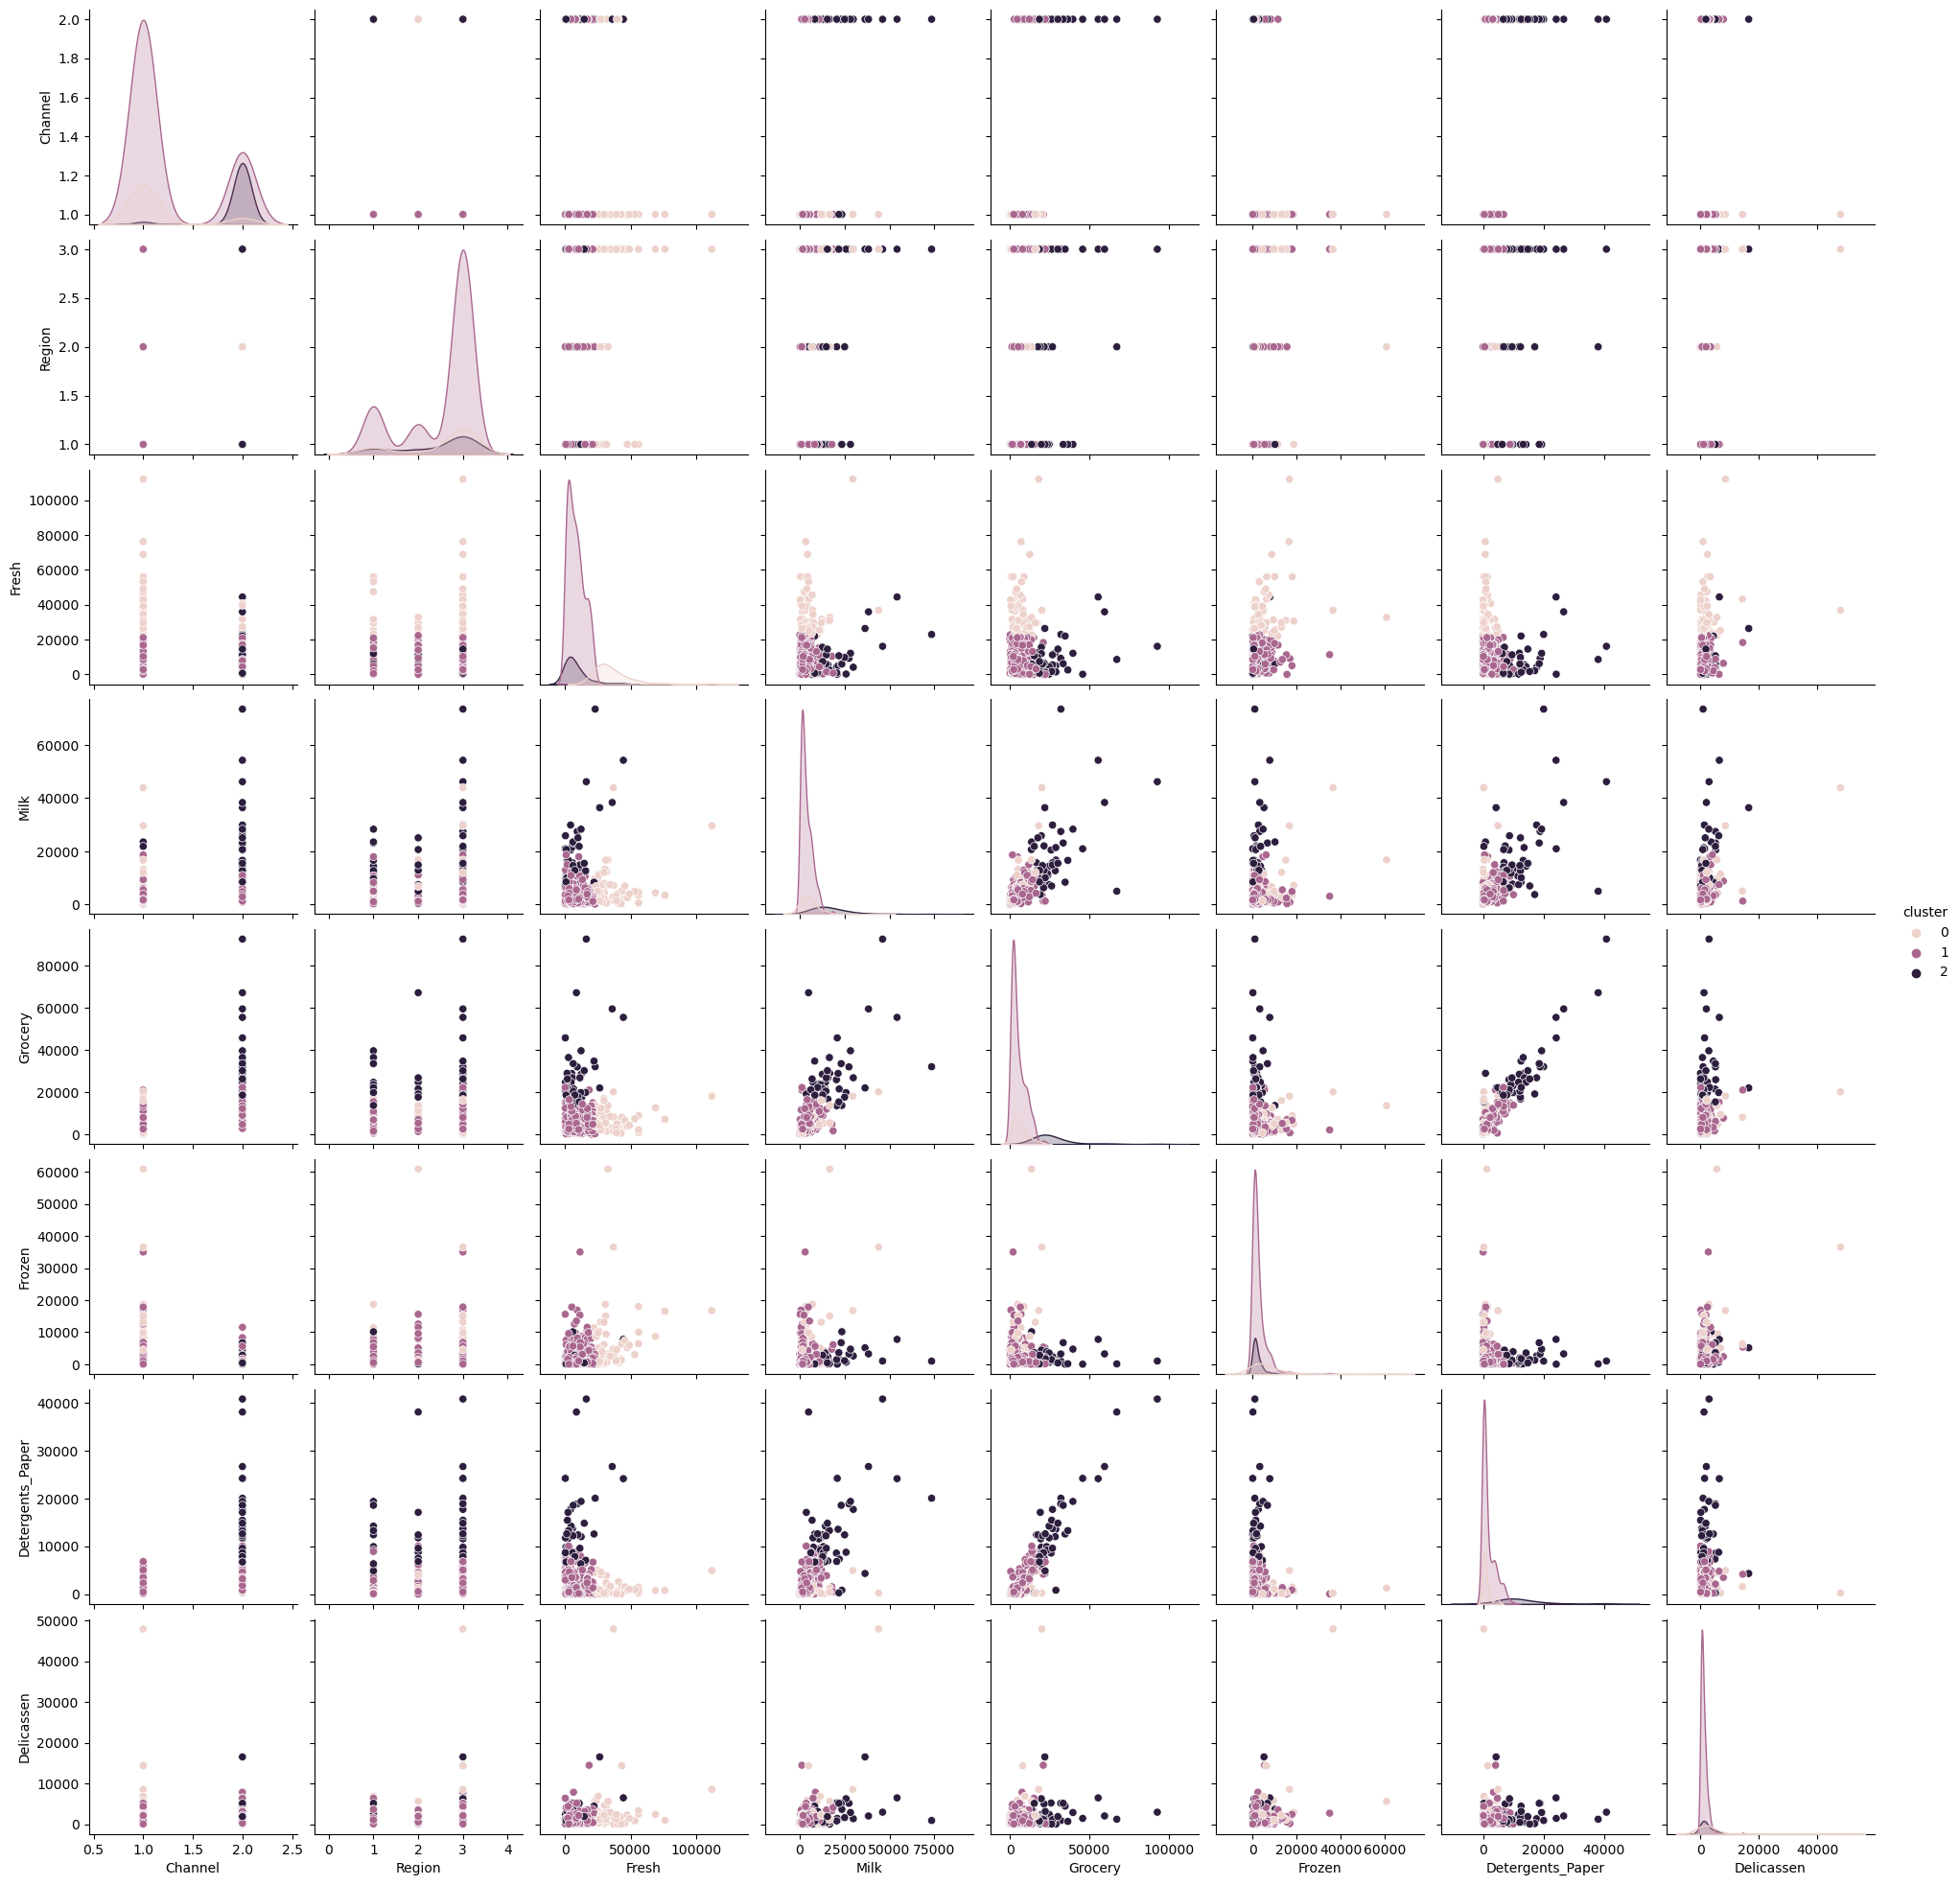

In [13]:
X['cluster']=y_km
sns.pairplot(X,hue='cluster');
plt.show();

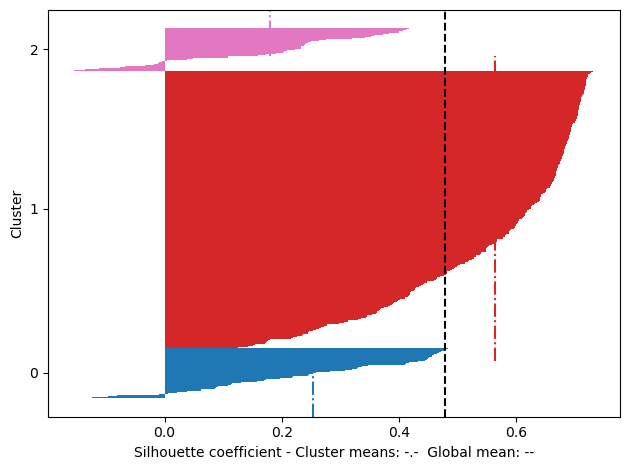

In [14]:
from plot_clusters import plot_clusters
from plot_silhouette_w_mean import plot_silhouette
silhouette_vals = silhouette_samples(X, y_km)
plot_silhouette(silhouette_vals,y_km)

### Comments
The __silhouette score__ ranges from `-1` (worst) to `1` (best); as a rule of thumb, a value near `0.5` should be considered acceptable.

Nevertheless, sometimes also smaller values are acceptable. In this case, cluster 1 has a good score, while 0 and 2 are less satisfactory


In [48]:
from matplotlib import cm
def boxplots(X, features
             , cluster_column='cluster'
             , title = 'Feature distributions per cluster'
             , cluster_colors=cm.tab10):
    """
    Given the dataframe X with a "cluster_column" produces the boxplots for every
    feature and for every cluster
    Args:
    X:              dataframe
    features:       the features to be plotted
    cluster_column: column of the cluster labels
    title:          title of the figure
    cluster_colors: color map
    """
    # cluster_colors = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']
    features = km.feature_names_in_
    ncols = 4
    nrows = len(features) // ncols + (len(features) % ncols > 0) # number of rows depends on the number of features
    fig = plt.figure(figsize=(15,10))

    for n, feature in enumerate(features):
        ax = plt.subplot(nrows, ncols, n + 1)
        box = X[[feature, cluster_column]].boxplot(by=cluster_column,ax=ax,return_type='both',patch_artist = True)

        for row_key, (ax,row) in box.iteritems():
            ax.set_xlabel(cluster_column)
            ax.set_title(feature,fontweight="bold")
            for i,box in enumerate(row['boxes']):
                # box.set_facecolor(cluster_colors[i])
                box.set_facecolor(cluster_colors(i))

    fig.suptitle(title, fontsize=18, y=1)   
    plt.tight_layout()
    plt.show()

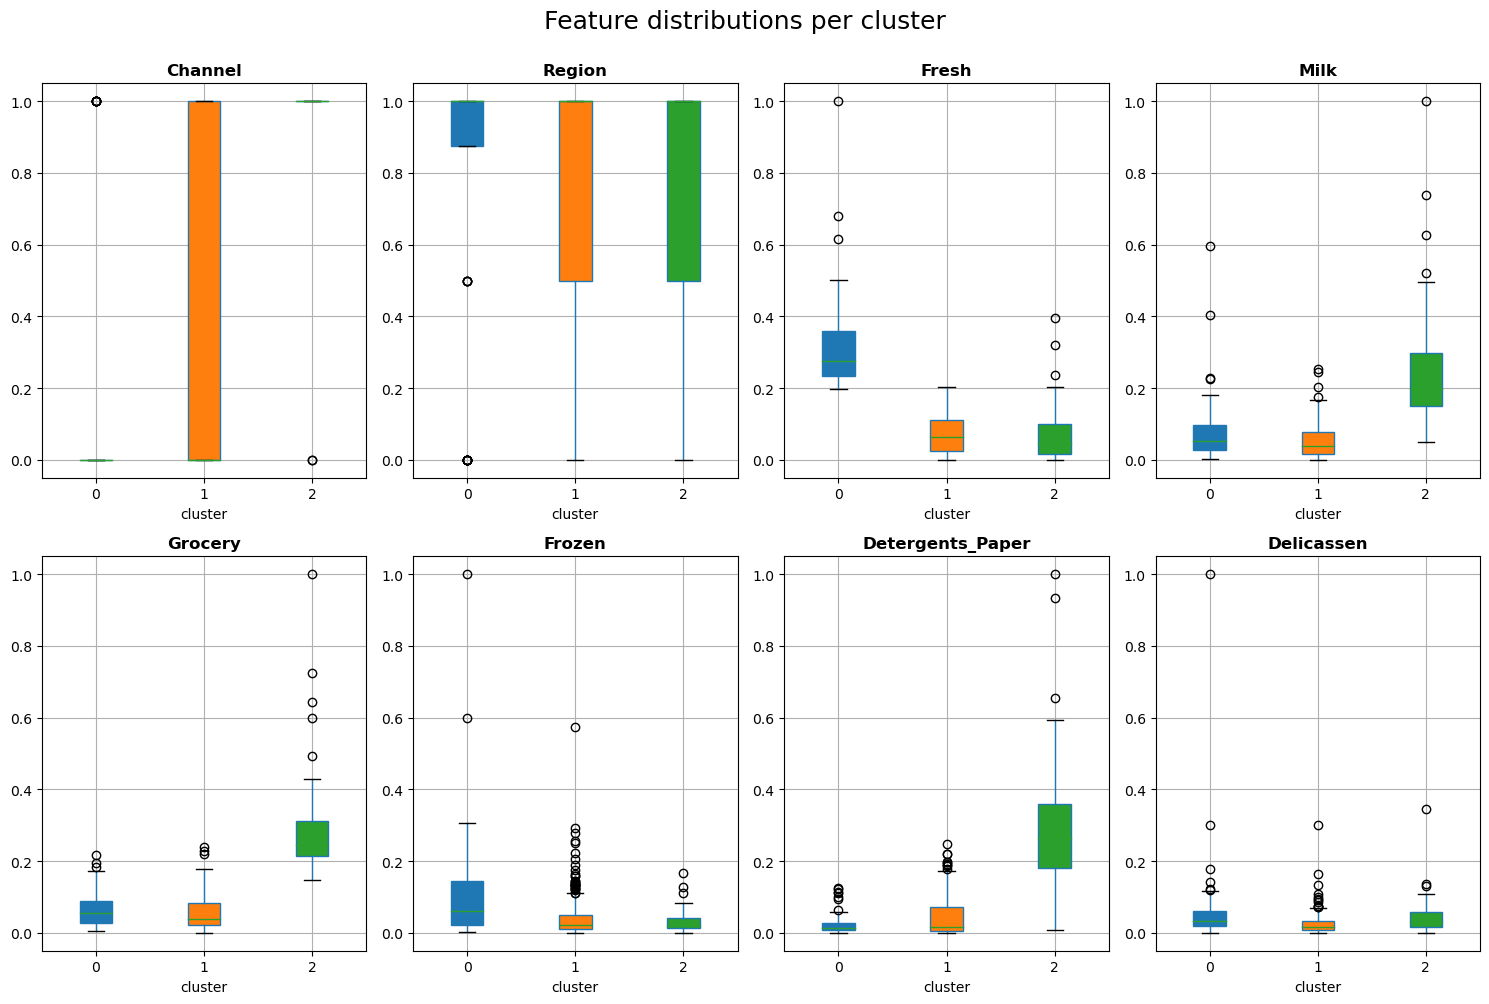

In [50]:
df_mms = pd.DataFrame(X_mms)
df_mms['cluster']=y_km
boxplots(df_mms, X.columns)